In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import metrics
import numpy as np

### Load & preprocess data

In [40]:
video_sent_file = "data/video_sent.csv"
video_acked_file = "data/video_acked.csv"

In [41]:
video_sent = pd.read_csv(video_sent_file)
video_acked = pd.read_csv(video_acked_file)

In [42]:
# merge video_sent & video_acked on session_id, index, & video_ts
merged_data = pd.merge(video_sent, video_acked, on=['session_id', 'index', 'video_ts'], suffixes=('_sent', '_acked'))
# debugging: time_sent & time_acked not in merged data
print("Columns in merged_data:", merged_data.columns)

Columns in merged_data: Index(['time (ns GMT)_sent', 'session_id', 'index', 'expt_id_sent',
       'channel_sent', 'video_ts', 'format', 'size', 'ssim_index', 'cwnd',
       'in_flight', 'min_rtt', 'rtt', 'delivery_rate', 'buffer_sent',
       'cum_rebuf_sent', 'time (ns GMT)_acked', 'expt_id_acked',
       'channel_acked', 'buffer_acked', 'cum_rebuf_acked'],
      dtype='object')


In [43]:
len(merged_data)

5174889

In [44]:
# rename columns for clarity
merged_data.rename(columns={
    'time (ns GMT)_sent': 'time_sent',
    'time (ns GMT)_acked': 'time_acked'
}, inplace=True)

### Feature engineering

In [45]:
# convert timestamps to datetime (easier to handle)
merged_data['time_sent'] = pd.to_datetime(merged_data['time_sent'], unit='ns')
merged_data['time_acked'] = pd.to_datetime(merged_data['time_acked'], unit='ns')

In [46]:
# download duration in seconds
merged_data['download_duration'] = (merged_data['time_acked'] - merged_data['time_sent']).dt.total_seconds()
#throughput in Mbps
merged_data['throughput'] = ((merged_data['size'] * 8) / merged_data['download_duration']) / 1000000
#byres per transmission time
merged_data['bytes_per_transmission_time'] = merged_data['size'] / merged_data['rtt']

In [47]:
merged_data.columns

Index(['time_sent', 'session_id', 'index', 'expt_id_sent', 'channel_sent',
       'video_ts', 'format', 'size', 'ssim_index', 'cwnd', 'in_flight',
       'min_rtt', 'rtt', 'delivery_rate', 'buffer_sent', 'cum_rebuf_sent',
       'time_acked', 'expt_id_acked', 'channel_acked', 'buffer_acked',
       'cum_rebuf_acked', 'download_duration', 'throughput',
       'bytes_per_transmission_time'],
      dtype='object')

In [48]:
merged_data.head()

,time_sent,session_id,index,expt_id_sent,channel_sent,video_ts,format,size,ssim_index,cwnd,...,buffer_sent,cum_rebuf_sent,time_acked,expt_id_acked,channel_acked,buffer_acked,cum_rebuf_acked,download_duration,throughput,bytes_per_transmission_time
0,2024-11-20 11:59:47.439,RhMF72kUi5Yin0hEqud4YQJiQ7UmZgNxk9YGk6A8UL0=,1,2216,abc,42209327160,1280x720-26,907262,0.949086,1090,...,0.000,0.000,2024-11-20 11:59:47.564,2216,abc,2.002,0.000,0.125,58.064768,16.567062
1,2024-11-20 11:59:47.568,RhMF72kUi5Yin0hEqud4YQJiQ7UmZgNxk9YGk6A8UL0=,1,2216,abc,42209507340,1280x720-20,947098,0.982131,1096,...,2.002,0.000,2024-11-20 11:59:47.693,2216,abc,3.931,0.166,0.125,60.614272,17.089462
2,2024-11-20 11:59:47.697,RhMF72kUi5Yin0hEqud4YQJiQ7UmZgNxk9YGk6A8UL0=,1,2216,abc,42209687520,1280x720-20,537024,0.989087,1010,...,3.931,0.166,2024-11-20 11:59:47.788,2216,abc,5.836,0.166,0.091,47.210901,9.923938
3,2024-11-20 11:59:47.792,RhMF72kUi5Yin0hEqud4YQJiQ7UmZgNxk9YGk6A8UL0=,1,2216,abc,42209867700,1280x720-20,402094,0.989844,1060,...,5.836,0.166,2024-11-20 11:59:47.895,2216,abc,7.733,0.166,0.103,31.230602,7.491690
4,2024-11-20 11:59:47.899,RhMF72kUi5Yin0hEqud4YQJiQ7UmZgNxk9YGk6A8UL0=,1,2216,abc,42210047880,1280x720-20,847411,0.987943,1060,...,7.733,0.166,2024-11-20 11:59:48.019,2216,abc,9.613,0.166,0.120,56.494067,15.061068


In [49]:
print(merged_data['size'].mean())
print(merged_data['size'].std())

894599.4501692693
622694.2741610612


In [ ]:
# select features
features = ['size', 'rtt', 'throughput', 'in_flight', 'bytes_per_transmission_time']
# size = chunk size in bytes
# rtt = RTT (sent) estimate
# throughput = Mbps
# in_flight = number of unacknowleged packets
target = 'download_duration'

In [51]:
#Try standardizing the data and see how that affects it? 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merged_data[features] = scaler.fit_transform(merged_data[['size', 'rtt', 'throughput', 'in_flight', 'bytes_per_transmission_time']])

In [52]:
# filter rows w missing vals in relevant features
merged_data = merged_data.dropna(subset=features + [target])

In [53]:
merged_data.head()

,time_sent,session_id,index,expt_id_sent,channel_sent,video_ts,format,size,ssim_index,cwnd,...,buffer_sent,cum_rebuf_sent,time_acked,expt_id_acked,channel_acked,buffer_acked,cum_rebuf_acked,download_duration,throughput,bytes_per_transmission_time
0,2024-11-20 11:59:47.439,RhMF72kUi5Yin0hEqud4YQJiQ7UmZgNxk9YGk6A8UL0=,1,2216,abc,42209327160,1280x720-26,0.020335,0.949086,1090,...,0.000,0.000,2024-11-20 11:59:47.564,2216,abc,2.002,0.000,0.125,0.220058,-0.126105
1,2024-11-20 11:59:47.568,RhMF72kUi5Yin0hEqud4YQJiQ7UmZgNxk9YGk6A8UL0=,1,2216,abc,42209507340,1280x720-20,0.084309,0.982131,1096,...,2.002,0.000,2024-11-20 11:59:47.693,2216,abc,3.931,0.166,0.125,0.266116,-0.113148
2,2024-11-20 11:59:47.697,RhMF72kUi5Yin0hEqud4YQJiQ7UmZgNxk9YGk6A8UL0=,1,2216,abc,42209687520,1280x720-20,-0.574239,0.989087,1010,...,3.931,0.166,2024-11-20 11:59:47.788,2216,abc,5.836,0.166,0.091,0.023978,-0.290877
3,2024-11-20 11:59:47.792,RhMF72kUi5Yin0hEqud4YQJiQ7UmZgNxk9YGk6A8UL0=,1,2216,abc,42209867700,1280x720-20,-0.790927,0.989844,1060,...,5.836,0.166,2024-11-20 11:59:47.895,2216,abc,7.733,0.166,0.103,-0.264714,-0.351205
4,2024-11-20 11:59:47.899,RhMF72kUi5Yin0hEqud4YQJiQ7UmZgNxk9YGk6A8UL0=,1,2216,abc,42210047880,1280x720-20,-0.075781,0.987943,1060,...,7.733,0.166,2024-11-20 11:59:48.019,2216,abc,9.613,0.166,0.120,0.191682,-0.163459


### Model training & evaluation

In [54]:
# edit: training taking a long time - using a subset of data: 
# subset_fraction = 0.2
# merged_data = merged_data.sample(frac=subset_fraction, random_state=42)

# split dataset
X = merged_data[features]
y = merged_data[target]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# model training
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1) # added n_jobs=-1 to use all CPU cores
rf_model.fit(X_train, y_train)

# evaluate model performance
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

In [56]:
# calc metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Training MAE: {train_mae}, RMSE: {train_rmse}")
print(f"Testing MAE: {test_mae}, RMSE: {test_rmse}")

Training MAE: 0.0002470418621644016, RMSE: 0.0224817203355096
Testing MAE: 0.0005276766274114654, RMSE: 0.03319053944548853


In [57]:
# feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error',  n_jobs=-1)
print(f"Cross-Validation MAE: {-np.mean(cv_scores)}")

# debugging: size of dataset & features: 
# print(f"Dataset size (used for training and testing): {merged_data.shape}")


Feature Importances:
                       Feature  Importance
2                   throughput    0.633821
0                         size    0.363194
1                          rtt    0.001768
4  bytes_per_transmission_time    0.000979
3                    in_flight    0.000238
Cross-Validation MAE: 0.0006237940834669076


In [58]:
self_collected_data = pd.read_csv("netUnicorn_data.csv")

In [59]:
self_collected_data.rename(columns={'dropped_packets': 'in_flight', 'total_tcp_len' : 'size'}, inplace=True)
self_collected_data.head()

,chunk,size,rtt,in_flight,time_chunk_sent,download_duration,throughput,bytes_per_transmission_time
0,1.0,612150,29.478,0,1.733946e+09,0.070587,69.378293,20766.334215
1,2.0,755212,2.173,0,1.733946e+09,0.006351,951.299260,347543.488265
2,3.0,490960,1.741,0,1.733946e+09,0.004152,945.959456,281998.851235
3,4.0,749005,275.777,1,1.733946e+09,3.042796,1.969255,2715.980666
4,5.0,865368,2.193,0,1.733946e+09,0.008722,793.749158,394604.651163


In [60]:
test_features = self_collected_data[features]
test_target = self_collected_data[target]

In [61]:
# Check for Inf or NaN values in the entire dataset
print(test_features.isna().sum())  # Check for NaN values
print((test_features == float('inf')).sum())  # Check for positive infinity
print((test_features == float('-inf')).sum())  # Check for negative infinity

# Optionally, check if any value is extremely large or too small for the float32 dtype
# Check for values exceeding a threshold (e.g., 1e10 or -1e10)
print((test_features > 1e10).sum())  # Check for values larger than 1e10
print((test_features < -1e10).sum())  # Check for values smaller than -1e10

# Find rows with large values in 'bytes_per_transmission_time'
large_values = test_features[test_features['bytes_per_transmission_time'] > 1e10]  # Adjust threshold as needed
print(large_values)

# Find rows with small values in 'bytes_per_transmission_time'
small_values = test_features[test_features['bytes_per_transmission_time'] < -1e10]  # Adjust threshold as needed
print(small_values)


size                           0
rtt                            0
throughput                     0
in_flight                      0
bytes_per_transmission_time    0
dtype: int64
size                           0
rtt                            0
throughput                     0
in_flight                      0
bytes_per_transmission_time    5
dtype: int64
size                           0
rtt                            0
throughput                     0
in_flight                      0
bytes_per_transmission_time    0
dtype: int64
size                           0
rtt                            0
throughput                     0
in_flight                      0
bytes_per_transmission_time    5
dtype: int64
size                           0
rtt                            0
throughput                     0
in_flight                      0
bytes_per_transmission_time    0
dtype: int64
        size  rtt  throughput  in_flight  bytes_per_transmission_time
303   505520  0.0  968.009842          0

In [62]:
# Calculate the median of the column excluding Inf
median_value = test_features['bytes_per_transmission_time'].replace(float('inf'), np.nan).median()

# Replace Inf values with the median
test_features['bytes_per_transmission_time'] = test_features['bytes_per_transmission_time'].replace(float('inf'), median_value)

/var/folders/72/cbn_92nn41ld5wwqrm521pxm000_7x/T/ipykernel_65874/2627338491.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features['bytes_per_transmission_time'] = test_features['bytes_per_transmission_time'].replace(float('inf'), median_value)


In [63]:
# Apply same scalar using in training 
# for consistency and for appropriate evaluation of MAE and RMSE
test_features[features] = scaler.transform(test_features[features])

/var/folders/72/cbn_92nn41ld5wwqrm521pxm000_7x/T/ipykernel_65874/1533859497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[features] = scaler.transform(test_features[features])


In [64]:
test_pred_new = rf_model.predict(test_features)

In [65]:
my_data_mae = mean_absolute_error(test_target, test_pred_new)
my_data_rmse = np.sqrt(mean_squared_error(test_target, test_pred_new))

print(f"Our Data MAE: {my_data_mae}, RMSE: {my_data_rmse}")

Our Data MAE: 0.007542749447970652, RMSE: 0.1616580426055047


Training score of pruned DT: 0.9305392775410929


/Users/ojonokuchi/anaconda3/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


[Text(0.5, 0.75, 'throughput <= -0.655\nsquared_error = 0.197\nsamples = 1400\nvalue = 0.324'),
 Text(0.25, 0.25, 'squared_error = 0.722\nsamples = 180\nvalue = 0.987'),
 Text(0.75, 0.25, 'squared_error = 0.045\nsamples = 1220\nvalue = 0.227')]

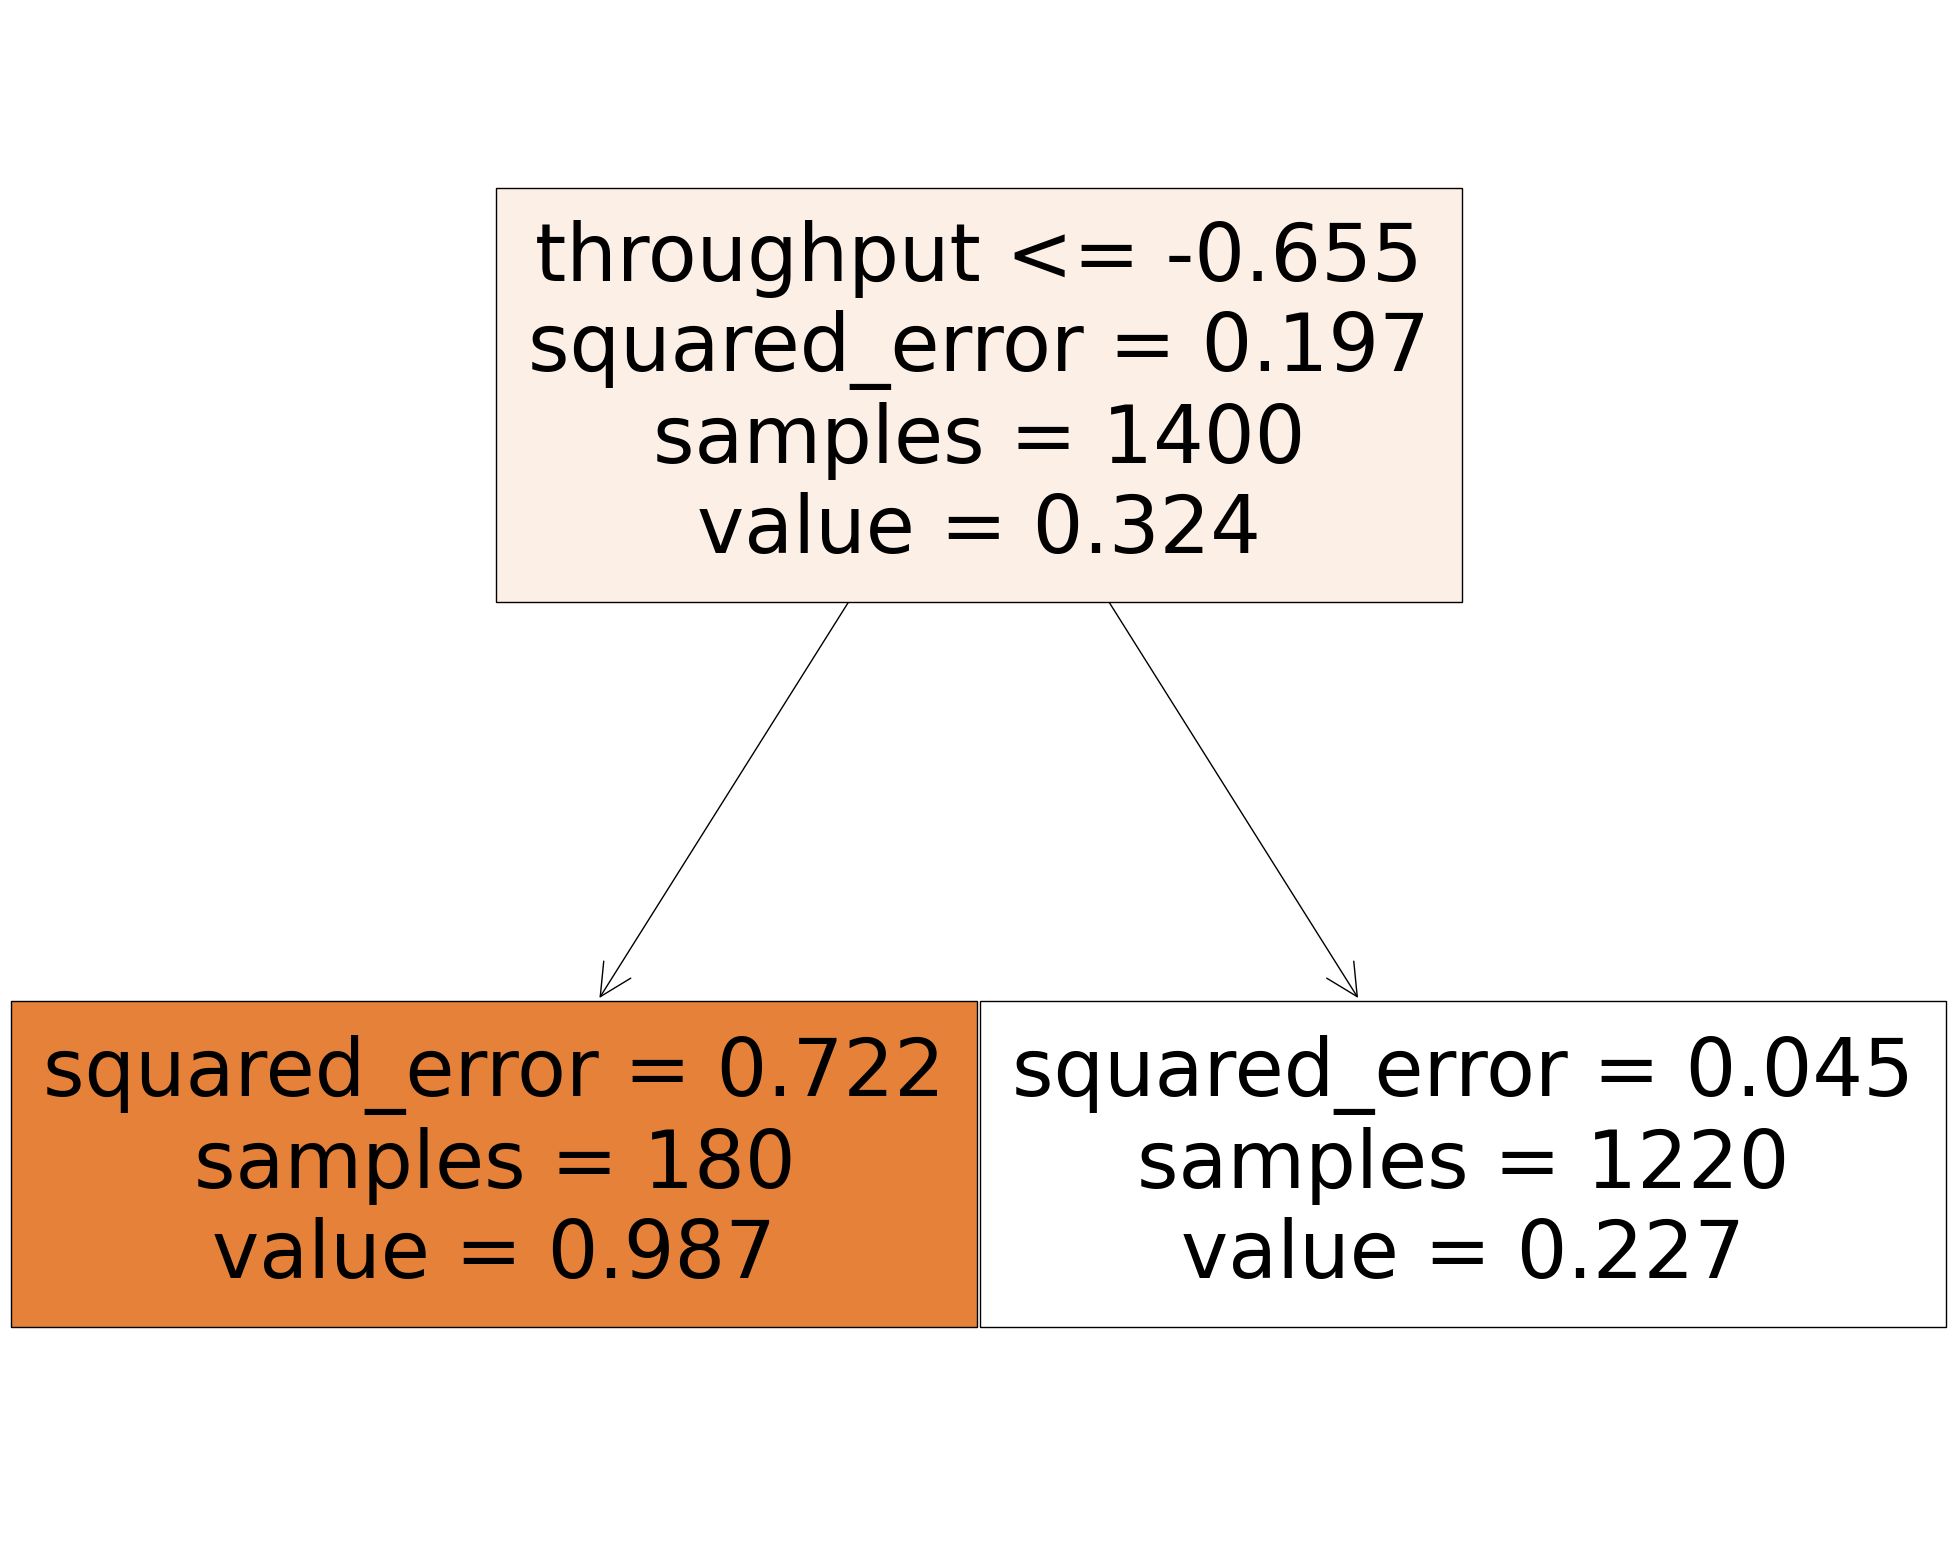

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from trustee import RegressionTrustee
from sklearn.tree import plot_tree

trustee = RegressionTrustee(expert=rf_model)
trustee.fit(X_train, y_train)
_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(X_train)

# plot a tree
fig = plt.figure(figsize=(25,20))
feature_names_list = X_train.columns.tolist()
plot_tree(dt, feature_names=feature_names_list, filled=True, max_depth=7)

[Text(0.5, 0.875, 'throughput <= -0.691\nsquared_error = 0.275\nsamples = 4139911\nvalue = 0.32'),
 Text(0.25, 0.625, 'size <= -0.325\nsquared_error = 1.689\nsamples = 397161\nvalue = 1.126'),
 Text(0.125, 0.375, 'throughput <= -0.817\nsquared_error = 1.127\nsamples = 297486\nvalue = 0.84'),
 Text(0.0625, 0.125, 'squared_error = 4.876\nsamples = 34830\nvalue = 2.0'),
 Text(0.1875, 0.125, 'squared_error = 0.427\nsamples = 262656\nvalue = 0.686'),
 Text(0.375, 0.375, 'throughput <= -0.807\nsquared_error = 2.394\nsamples = 99675\nvalue = 1.98'),
 Text(0.3125, 0.125, 'squared_error = 68.252\nsamples = 829\nvalue = 11.39'),
 Text(0.4375, 0.125, 'squared_error = 1.093\nsamples = 98846\nvalue = 1.901'),
 Text(0.75, 0.625, 'throughput <= -0.462\nsquared_error = 0.049\nsamples = 3742750\nvalue = 0.235'),
 Text(0.625, 0.375, 'size <= 0.119\nsquared_error = 0.108\nsamples = 871261\nvalue = 0.424'),
 Text(0.5625, 0.125, 'squared_error = 0.028\nsamples = 684448\nvalue = 0.306'),
 Text(0.6875, 0.125

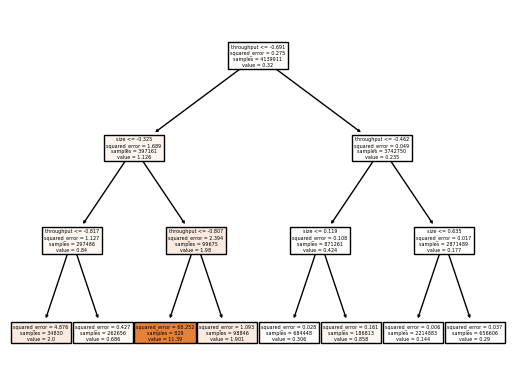

In [67]:
from sklearn.tree import DecisionTreeRegressor
# sanity check: train a raw decision tree on the same data 
# w/o constraints of RegressionTrustee 
# from sklearn.tree import DecisionTreeRegressor

dt_lpruned = DecisionTreeRegressor(max_depth=3, min_samples_split=2)
dt_lpruned.fit(X_train, y_train)

# Plot less pruned tree
plot_tree(dt_lpruned, feature_names=X_train.columns.tolist(), filled=True)

In [68]:
self_collected_data2 = pd.read_csv("self_collected_data.csv")
self_collected_data2.rename(columns={'dropped_packets': 'in_flight', 'total_tcp_len' : 'size'}, inplace=True)
self_collected_data2.head()
test_features2 = self_collected_data2[features]
test_target2 = self_collected_data2[target]

In [69]:
# Apply same scalar using in training 
# for consistency and for appropriate evaluation of MAE and RMSE
test_features2[features] = scaler.transform(test_features2[features])

/var/folders/72/cbn_92nn41ld5wwqrm521pxm000_7x/T/ipykernel_65874/2389705618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features2[features] = scaler.transform(test_features2[features])


In [70]:
# Check for Inf or NaN values in the entire dataset
print(test_features2.isna().sum())  # Check for NaN values
print((test_features2 == float('inf')).sum())  # Check for positive infinity
print((test_features2 == float('-inf')).sum())  # Check for negative infinity

# Optionally, check if any value is extremely large or too small for the float32 dtype
# Check for values exceeding a threshold (e.g., 1e10 or -1e10)
print((test_features2 > 1e10).sum())  # Check for values larger than 1e10
print((test_features2 < -1e10).sum())  # Check for values smaller than -1e10

# Find rows with large values in 'bytes_per_transmission_time'
large_values2 = test_features2[test_features2['bytes_per_transmission_time'] > 1e10]  # Adjust threshold as needed
print(large_values2)

# Find rows with small values in 'bytes_per_transmission_time'
small_values2 = test_features2[test_features2['bytes_per_transmission_time'] < -1e10]  # Adjust threshold as needed
print(small_values2)

# Calculate the median of the column excluding Inf
median_value2 = test_features2['bytes_per_transmission_time'].replace(float('inf'), np.nan).median()

# Replace Inf values with the median
test_features2['bytes_per_transmission_time'] = test_features2['bytes_per_transmission_time'].replace(float('inf'), median_value2)

size                           0
rtt                            0
throughput                     0
in_flight                      0
bytes_per_transmission_time    0
dtype: int64
size                           0
rtt                            0
throughput                     0
in_flight                      0
bytes_per_transmission_time    0
dtype: int64
size                           0
rtt                            0
throughput                     0
in_flight                      0
bytes_per_transmission_time    0
dtype: int64
size                           0
rtt                            0
throughput                     0
in_flight                      0
bytes_per_transmission_time    0
dtype: int64
size                           0
rtt                            0
throughput                     0
in_flight                      0
bytes_per_transmission_time    0
dtype: int64
Empty DataFrame
Columns: [size, rtt, throughput, in_flight, bytes_per_transmission_time]
Index: []
Empty DataF

/var/folders/72/cbn_92nn41ld5wwqrm521pxm000_7x/T/ipykernel_65874/2401524010.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features2['bytes_per_transmission_time'] = test_features2['bytes_per_transmission_time'].replace(float('inf'), median_value2)


In [71]:
test_pred_new2 = rf_model.predict(test_features2)
our_data_mae = mean_absolute_error(test_target2, test_pred_new2)
our_data_rmse = np.sqrt(mean_squared_error(test_target2, test_pred_new2))

print(f"Our Data MAE: {our_data_mae}, RMSE: {our_data_rmse}")

Our Data MAE: 0.0002208422851562705, RMSE: 0.00031158825404567465
